# Generating synthetic text using Large Language Models from Hugging Face

[![Run on Colab](https://img.shields.io/badge/Open%20in-Colab-blue?logo=google-colab)](https://colab.research.google.com/github/mostly-ai/mostlyai/blob/main/docs/tutorials/synthetic-text/synthetic-llm-text.ipynb)

In this notebook, we demonstrate how to synthesize free text columns using large language models with billions of parameters from [Hugging Face](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending).

Note, that the usage of a GPU, with 24GB or more, is strongly recommended for running this tutorial.

Technical aside: MOSTLY AI's implementation uses techniques such as parameter efficient fine-tuning, quantization, and activation checkpointing to train large language models in a memory efficient manner. Therefore, even if using a GPU with 24GB of memory, you should be able to train LLMs with billions of parameters. These are technical details hidden from the user, but it's important to understand that you are not as limited as you may first think.

## Synthesize Data via MOSTLY AI

In [3]:
# !pip install -U 'mostlyai[local-gpu]'

# # for runpod, run these commands and then restart the kernel
# !pip uninstall -y typing_extensions
# !pip install typing_extensions==4.10.0

INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.4/602.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 19.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 32.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.1 MB/s eta 0:00:00
 

In [1]:
import pandas as pd

# fetch original data
df = pd.read_parquet("https://github.com/mostly-ai/public-demo-data/raw/dev/headlines/headlines.parquet")

# split into train and holdout sets, we will use the holdout set to evaluate the performance of the generator later in the tutorial
tgt = df.sample(frac=0.9, random_state=42)
tgt_holdout = df.drop(tgt.index)
tgt[["headline", "category"]].head(5)

,headline,category
61893,Fascinating Video Uncovers What's Inside A Rat...,WEIRD NEWS
121661,Reinventing Reality: An Interview With The 'Pa...,ARTS
6996,U.S. Schools Have Already Faced 10 Shooting In...,CRIME
83678,Suicides In Jails On The Rise: Report,CRIME
124675,"This Gay Teen Was Thrown Out Of His Home, Arre...",QUEER VOICES


In [2]:
from mostlyai.sdk import MostlyAI

# initialize SDK
mostly = MostlyAI(local=True)  # or: MostlyAI(base_url='xxx', api_key='xxx')

Starting server on ]8;id=120082;http://127.0.0.1:62967\http://127.0.0.1:62967]8;;\ using ]8;id=77702;file:///root/mostlyai\file:///root/mostlyai]8;;\

Connected to ]8;id=328119;http://127.0.0.1:62967\http://127.0.0.1:62967]8;;\ (4.0.6)

In [6]:
# Train a generator on the dataset
huggingface_model = "Qwen/Qwen2.5-1.5B"  # "meta-llama/Llama-3.2-1B"  # specify any Hugging Face language model that fits on a single GPU such as Mistral, Llama, Qwen, and so forth
config = {
    "name": "Synthetic Text Tutorial",
    "tables": [
        {
            "name": "headlines",
            "data": tgt,
            "tabular_model_configuration": {"max_training_time": 5},
            "language_model_configuration": {
                "max_training_time": 20,
                "model": huggingface_model,
            },  # we suggest training for ~10-20 minutes if training on an A10G or similar GPU.
            "columns": [
                {"name": "category", "model_encoding_type": "TABULAR_CATEGORICAL"},
                {"name": "headline", "model_encoding_type": "LANGUAGE_TEXT"},
            ],
        }
    ],
}

# The first time this is run, it may take some time to download the large language model (a one billion parameter model is typically a few GB), but subsequent runs will be faster since the model is cached.
g_headlines = mostly.train(config=config)

Created generator ]8;id=811613;http://127.0.0.1:62967/d/generators/6d1c3727-9cef-4e8d-863b-843807c499b6\6d1c3727-9cef-4e8d-863b-843807c499b6]8;;\

Started generator training

Output()

Overall job progress                               ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━  75% 0:13:15
Step headlines:tabular PULL_TRAINING_DATA          ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Step headlines:tabular ANALYZE_TRAINING_DATA       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:04
Step headlines:tabular ENCODE_TRAINING_DATA        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:02
Step headlines:tabular TRAIN_MODEL 💎              ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:12
Step headlines:tabular GENERATE_MODEL_REPORT_DATA  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Step headlines:tabular CREATE_MODEL_REPORT         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:20
Step headlines:language PULL_TRAINING_DATA         ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:02
Step headlines:language ANALYZE_TRAINING_DATA      ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:08
Step headlines:language ENCODE_TRAINING_DATA       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:18
Step headlines:language TRAIN_MODEL 💎             ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━  46% 0:12:04
Step headlines:language GENERATE_MODEL_REPORT_DATA ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--
Step headlines:language CREATE_MODEL_REPORT        ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

/usr/local/lib/python3.11/dist-packages/transformers/integrations/peft.py:418: FutureWarning:

The `active_adapter` method is deprecated and will be removed in a future version.



Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.31it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.31it/s]



Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.18it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.18it/s]



🎉 Your generator is ready! Use it to create synthetic data. Publish it so others can do the same.

In [8]:
# generate a synthetic dataset
syn = mostly.generate(generator=g_headlines, size=5000).data()
print(f"Created synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

Created synthetic dataset ]8;id=250069;http://127.0.0.1:62967/d/synthetic-datasets/fc2f0b78-4f80-46f9-bec7-a39b02a549c4\fc2f0b78-4f80-46f9-bec7-a39b02a549c4]8;;\ with generator ]8;id=795411;http://127.0.0.1:62967/d/generators/6d1c3727-9cef-4e8d-863b-843807c499b6\6d1c3727-9cef-4e8d-863b-843807c499b6]8;;\

Started synthetic dataset generation

Output()

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.28it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.28it/s]



🎉 Your synthetic dataset is ready! Use it to consume the generated data. Publish it so others can do the same.

Created synthetic data with 5,000 records and 2 attributes


## Explore Synthetic Text

Show 10 randomly sampled synthetic records. Note that you can execute the following cell multiple times to see different samples.

In [9]:
response = mostly.synthetic_datasets.get(list(mostly.synthetic_datasets.list())[-1].id)
syn = response.data()

In [10]:
syn.sample(n=10)

,category,headline
2673,ARTS,NOMADS: Queens Football 2015
3808,WELLNESS,Strengthening the Mind: An Art of Greatness
3010,POLITICS,Sen. John Cornyn Says He'll Quit If Democrats ...
2337,HOME & LIVING,How To Create Fantastic People Space Through D...
1013,POLITICS,Cavuto Says He's Thought About Running Against...
4232,ENTERTAINMENT,Paris Hilton New Bad Romance Breast Photo
1707,CRIME,Aggrieved Dogs Administer Stunning Tongue Slas...
1036,WEIRD NEWS,Man Surfaces Pop Tart Stylishly In Glow-In-The...
2021,SPORTS,Drew Brees Proving On-Field Proof For Proteste...
3727,PARENTING,"64 Stars Find Their Way On Us, And 10 Are Like..."


Compare this to 10 randomly sampled original records.

In [11]:
tgt.sample(n=10)

,category,date,headline
172271,PARENTING,2012-11-28,"Michelle Nagle, Mom, Tells Story Behind Powerf..."
172402,STYLE & BEAUTY,2012-11-27,James Middleton Debuts Facial Hair (PHOTOS)
24419,IMPACT,2017-06-09,Reflections On Dr. Samuel DuBois Cook: A Great...
52706,POLITICS,2016-07-21,HUFFPOST HILL - Media To Cover Donald Trump Sp...
186643,STYLE & BEAUTY,2012-06-26,Are Kristen Stewart's Jeans Wedding Appropriate?
44742,POLITICS,2016-10-20,Donald Trump Claims Hillary Clinton Saw Debate...
128221,WELLNESS,2014-03-11,To My Son
193882,WELLNESS,2012-04-09,Staying Active Could Protect Elderly From Psyc...
53381,SPORTS,2016-07-14,"Zaevion Dobson Was A Hero. Now His Mother Is, ..."
169885,CRIME,2012-12-24,"4 Firefighters Shot, 2 Killed At Webster, New ..."


### How does the synthetic data compare to the original data when taking categories into account?

Next we perform a sanity check to see if the synthetic data is similar to the original data when taking categories into account. We take each headline, and encode it using a sentence transformer. We then perform PCA dimensionality reduction on the resulting embeddings and visualize the first two principal components. If the synthetic data is similar to the original data, we should see that the synthetic data has similar distribution of categories as the original data.

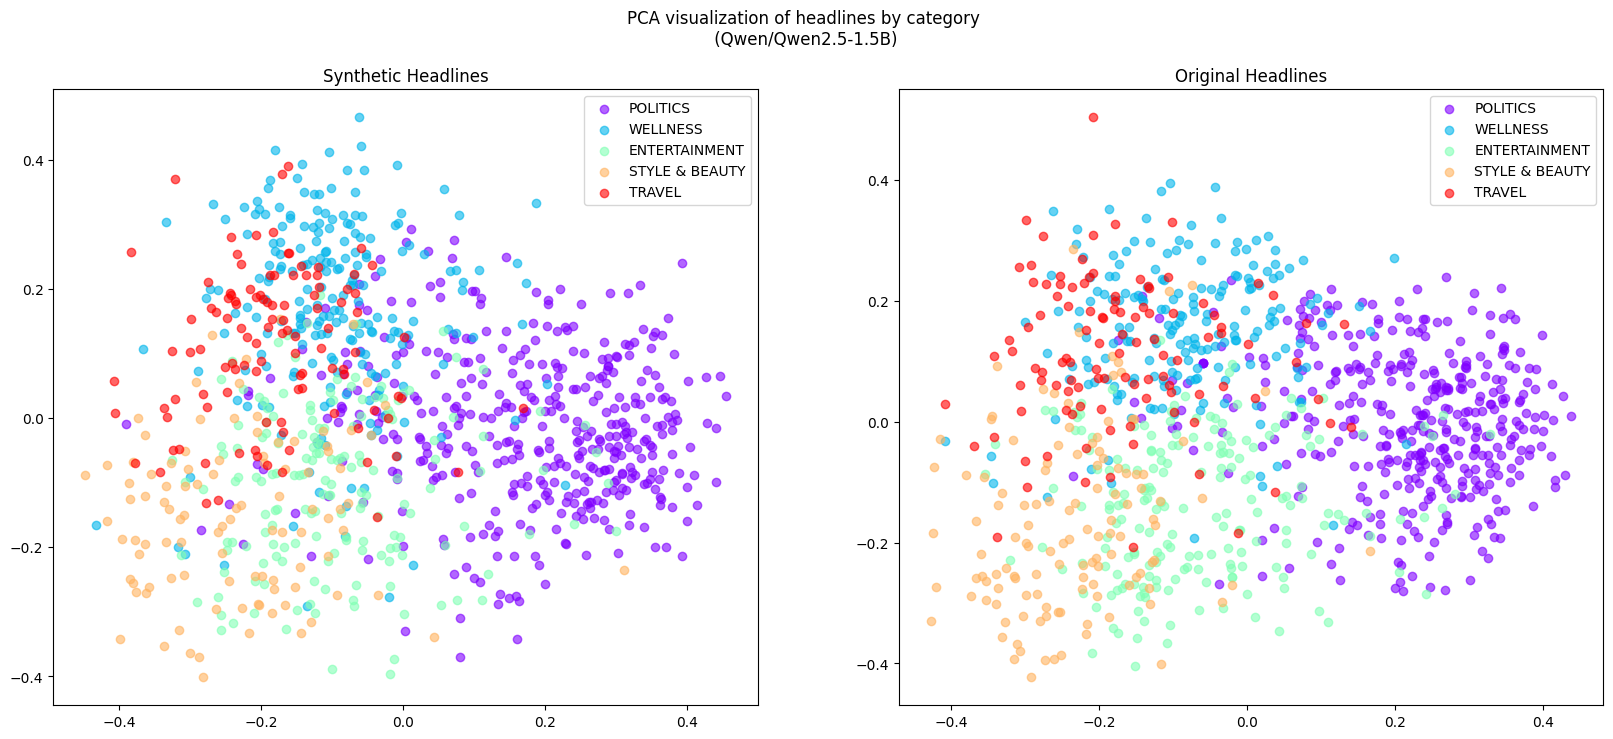

In [16]:
# perform PCA dimensionality reduction and visualization
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# get sentence embeddings for both datasets
model = SentenceTransformer("all-MiniLM-L6-v2")

# get the 5 most frequent categories
value_counts = syn["category"].value_counts()
selected_categories = value_counts.head(5).index

# filter datasets to only include most frequent categories
tgt_head = tgt[tgt["category"].isin(selected_categories)].sample(1000)
syn_head = syn[syn["category"].isin(selected_categories)].sample(1000)

tgt_features = model.encode(tgt_head["headline"].tolist())
syn_features = model.encode(syn_head["headline"].tolist())

# apply PCA to both datasets
pca = PCA(n_components=2, random_state=42)
combined = np.vstack((syn_features, tgt_features))
pca.fit(combined)  # important: fit PCA on the combined data
syn_pca = pca.transform(syn_features)
tgt_pca = pca.transform(tgt_features)

# plot the PCA results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_categories)))

# plot synthetic data
for category, color in zip(selected_categories, colors):
    mask = syn_head["category"] == category
    ax1.scatter(syn_pca[mask, 0], syn_pca[mask, 1], c=[color], label=category, alpha=0.6)
ax1.set_title("Synthetic Headlines")
ax1.legend()

# plot original data
for category, color in zip(selected_categories, colors):
    mask = tgt_head["category"] == category
    ax2.scatter(tgt_pca[mask, 0], tgt_pca[mask, 1], c=[color], label=category, alpha=0.6)
ax2.set_title("Original Headlines")
ax2.legend()

plt.suptitle(f"PCA visualization of headlines by category\n ({huggingface_model})")
plt.show()

### Train a classifier on the synthetic data, and evaluate its performance on the real (original) data.

At the beginning of this tutorial, we saved a holdout set of the original data `tgt_holdout` which we did not use to train the generator. We will now use this holdout set to evaluate the performance of a classifier trained on the synthetic data, and then compare it to the performance of a classifier trained on the original data (without the holdout set) to see how much information is retained in the synthetic data.

In [18]:
# train simple classifier on the synthetic data, and evaluate its performance on the real data holdout
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# embed the synthetically generated data
syn_train_features = model.encode(syn_head["headline"].tolist())
syn_train_labels = syn_head["category"].tolist()

# filter holdout data to only include categories present in synthetic data
mask = tgt_holdout["category"].isin(syn_train_labels)
tgt_holdout_features = model.encode(tgt_holdout[mask]["headline"].tolist())
tgt_holdout_labels = tgt_holdout[mask]["category"].tolist()

# train classifier on synthetic data
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(syn_train_features, syn_train_labels)

# evaluate on holdout set
val_pred = clf.predict(tgt_holdout_features)
print("Trained on Synthetic data, evaluated on real data holdout:")
print(classification_report(tgt_holdout_labels, val_pred))

Original holdout set performance:
                precision    recall  f1-score   support

 ENTERTAINMENT       0.78      0.72      0.75      1607
      POLITICS       0.81      0.96      0.88      3310
STYLE & BEAUTY       0.85      0.64      0.73       976
        TRAVEL       0.88      0.73      0.80       983
      WELLNESS       0.84      0.81      0.82      1799

      accuracy                           0.82      8675
     macro avg       0.83      0.77      0.80      8675
  weighted avg       0.82      0.82      0.82      8675



In [20]:
# for comparison, we train a simple classifier on the real data and evaluate its performance on the real data holdout
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# embed the real training data
tgt_features = model.encode(tgt_head["headline"].tolist())
tgt_labels = tgt_head["category"].tolist()

# train classifier on real data
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(tgt_features, tgt_labels)

# evaluate on holdout set
val_pred = clf.predict(tgt_holdout_features)
print("Trained on real data, evaluated on real data holdout:")
print(classification_report(tgt_holdout_labels, val_pred))

Trained on real data, evaluated on real data holdout:
                precision    recall  f1-score   support

 ENTERTAINMENT       0.80      0.81      0.80      1607
      POLITICS       0.89      0.94      0.91      3310
STYLE & BEAUTY       0.85      0.72      0.78       976
        TRAVEL       0.86      0.77      0.81       983
      WELLNESS       0.84      0.85      0.84      1799

      accuracy                           0.85      8675
     macro avg       0.85      0.82      0.83      8675
  weighted avg       0.85      0.85      0.85      8675



The synthetic data retains a lot of the structure of the original data, and the classifier trained on the synthetic data should perform similarly to the classifier trained on the original data.

## Conclusion
In this tutorial, we demonstrated how to train a large language model to generate synthetic text conditioned on synthetic tabular data using MOSTLY AI's SDK. We analyzed the generated texts and showed that the synthetic data was of similar structure as the original data. We then proceeded to train a classifier on the synthetic data, and evaluated its performance on the original data.

This feature allows the user to make use of the world knowledge encoded in large language models to generate synthetic text data, all while retaining the structure of the original data.

## Further exercises

In addition to walking through the above instructions, we suggest..
* try seeded generation, condition your LLM on different data
* try using a different dataset
* try multi-billion parameter models

## References<a class="anchor" name="refs"></a>

1. https://github.com/mostly-ai/public-demo-data/blob/dev/firstnames_at/firstnames_at.csv.gz
1. https://www.frontiersin.org/articles/10.3389/fdata.2021.679939/full
1. https://mostly.ai/blog/truly-anonymous-synthetic-data-legal-definitions-part-ii/